# Population inference with a gaussian toy model

The purpose of this code is to infer the hyperparameters of a model distribution using emcee. We choose to work with a simple gaussian model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib as mpl
import seaborn as sns


%matplotlib inline
np.random.seed(1234)

In [2]:
# Nice plotting options.

params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

CORNER_KWARGS = dict(
    smooth=0.2, # smooths out contours. 
    plot_datapoints=True, # choose if you want datapoints
    label_kwargs=dict(fontsize=17.0), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=17.0), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=4, # set a limit to ticks in the x-y axes.
    title_fmt=".1e", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # Reverse the contour.
)

### Model definition & data generation

We generate data here starting from the chosen gaussian model with hyperparameters $\lambda$,

$$
\begin{equation}
\tag{1}
p(d|\lambda=\{\mu,\Sigma^2\})= \int p(d|\theta) p(\theta|\lambda) d\theta =  \mathcal{N}(\mu,\sigma^2+\Sigma^2),
\end{equation}
$$

where the observation model $p(d|\theta)$ and population model $p(\theta|\lambda)$ are taken to be

$$
p(d|\theta) = \mathcal{N}(\theta,\sigma^2), \quad p(\theta|\lambda)= \mathcal{N}(\mu,\Sigma^2).
$$

The observation model is appropriate to a noisy data stream  $d= n + \theta$ where $p(n)=\mathcal{N}(0,\sigma^2)$.

$\textit{Note}$: in this simplified scenario we can draw data from the hyperparameters from a gaussian only because we assume both observation model and signal model to be gaussians. In more complicated scenarios each assumption might be violated. 

In [3]:
# Choose a high enough Number of observations for this tutorial.
N_obs = 100000


# Hyperparameters to sample in the MCMC.

true_mu = 0.5
true_Sigma_sq = 1.5

# Data.

Sigma = np.sqrt(true_Sigma_sq)
sigma = 0.2
std = np.sqrt(Sigma**2 + sigma**2)

data  = np.random.normal(true_mu,std,size=N_obs)

## Case I: MCMC without selection effects

The first case we consider is the one in which we do not impose any cutoff on the data. That is, we do not include selection bias in the data generation process. Then the data generated above is the one used in the MCMC, and it looks like as follows.

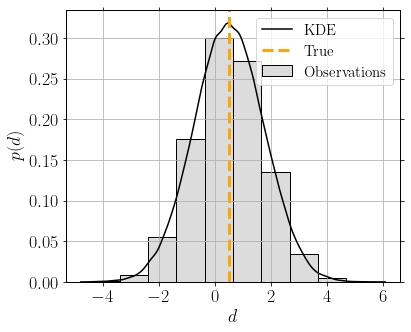

In [4]:
# Plot the generated data.

fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(data,density=True,label='Observations',bins=10,histtype = 'bar',
                               color ='gainsboro', edgecolor='black')
sns.kdeplot(np.array(data), label='KDE',c='k')
plt.axvline(x=true_mu, label='True', c='orange',ls='--',lw=3)

plt.xlabel('$d$')
plt.ylabel('$p(d)$')
plt.legend(loc='best')

Below we define the model we use in the MCMC analysis. For this simplified scenario, we assume $\sigma^2$ is known in the variance, since in the end we want to compare posterior samples with expressions that do contain this element $\sigma^2$.

The fact above however does not mean we do not expect biases, since we draw $p(d|\lambda)$ from a random.normal distribution, which reintroduces an element of statistical noise.

In [5]:
def model(d,mu,Sigma_sq):
    
    """
    Model for p(d|lambda).
    
    Input:
    
    - data              (The noisy generated data where we expect theta to be.)
    - mu                (First  hyperparameter, "param[0]" in MCMC initialization.)
    - Sigma^2 + sigma^2 (Second hyperparameter, "param[1]" in MCMC initialization.)
    
    """
    num = np.exp(-0.5*(d-mu)**2/Sigma_sq)
    den = np.sqrt(2*np.pi*Sigma_sq)
    return num/den

Below we define the likelihood. In principle we define it as the product of the gaussians from individual observations,

$$
p(d|\lambda) \equiv \Lambda = \prod_{i=1}^{N_\text{obs}} p(d_i|\lambda), \quad
\log \Lambda = \sum_{i}^{N_\text{obs}} \log p(d_i|\lambda)
,
$$

where $d_i$ are draws from the data array.

$\textit{Note:}$ in this case the model is simple enough that we have the luxury to sample directly $p(d|\lambda)$. Thus we bypass the need to draw samples $p(d|\theta)$ to marginalize over source parameters $\theta$ with a population model $p(\theta|\lambda)$.

In [6]:
# Define limits of support for the likelihood, i.e. the limits of flat priors.

mean_min_prior = -5.0
mean_max_prior = 5.0

Sigma_sq_min_prior = -5.0
Sigma_sq_max_prior = 5.0


def log_likelihood(params, data):
    
    # Specify a set of flat priors.
    support = (
                (params[0] >= mean_min_prior)&
                (params[0] <= mean_max_prior)&
                (params[1] >= Sigma_sq_min_prior)&
                (params[1] <= Sigma_sq_max_prior)
                )
    
    #Likelihood is a gaussian with mean given by params[0] and Sigma given by params[1].
    #Sum in the log-likelihood sums over individual observations.
    
    mod = model(data,params[0],params[1])
    log_likelihood = np.sum(np.log(mod))

    
    # Output is the likelihood where there is support.
    
    out = np.where(support,log_likelihood,-np.inf)
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf

In [9]:
n_iter = 10000
ndim, nwalkers = 2, 4

# Initialize MCMC: here's where params[0] and params[1] are effectively defined.

pos_init0 = [true_mu, true_Sigma_sq + sigma**2]

# Perturb the initial position by a bit, so that we do not start exactly on top of 
# the hyperparameters we want to infer.

p0 = pos_init0*(1+0.001* np.random.randn(2*len(pos_init0), len(pos_init0)))


# Run the MCMC here.

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data])
run = sampler.run_mcmc(p0, n_iter, progress=True)

100%|████████████████████████████████████| 10000/10000 [00:56<00:00, 176.08it/s]


In [10]:
"""
Collect the samples here.
"""
burnin = 1500 # discard first 1500 points.

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
mu_samples = chains[:,:,0].flatten()
Sigma2_samples = chains[:,:,1].flatten() - sigma**2 # remove sigma component to show results for Sigma^2 only.

In [11]:
#import pickle

#with open('data_files/mu_samples.pickle', 'wb') as handle:
#    pickle.dump(mu_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('data_files/Sigma2_samples.pickle', 'wb') as handle:
#    pickle.dump(Sigma2_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
"""
Gather all the relevant samples here. The stacking here is needed for the corner plot.
"""

org_samp = np.vstack( (mu_samples, Sigma2_samples) ).T

print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (34000, 2)
median =  [0.50130804 1.50197059]


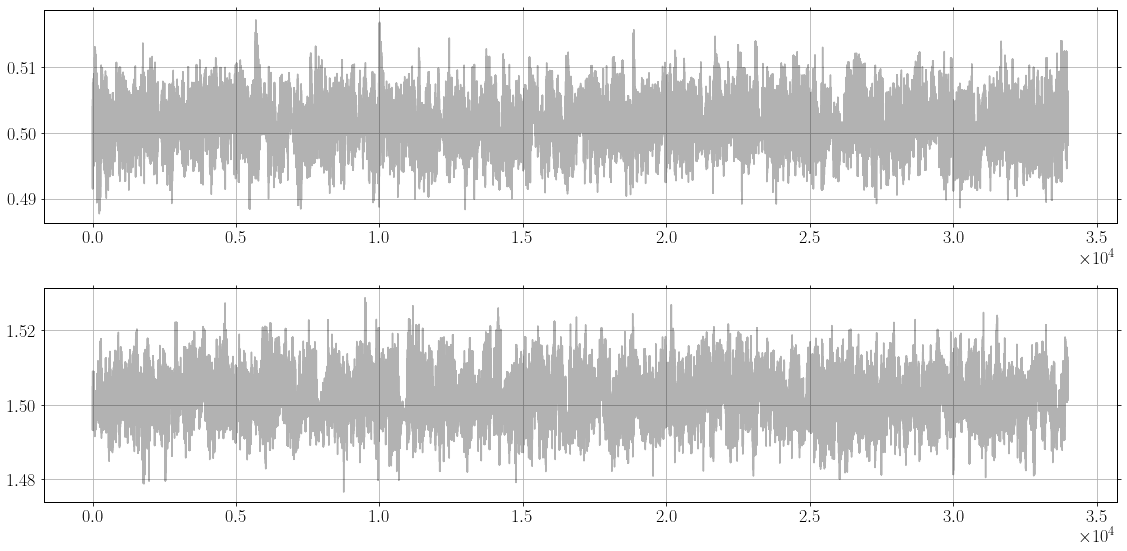

In [13]:
"""
Plot the traces.
"""

fig,ax = plt.subplots(len(pos_init0),figsize = (16,8))

ax[0].plot(mu_samples, "k", alpha=0.3)
ax[1].plot(Sigma2_samples, "k", alpha=0.3)
plt.tight_layout()
plt.show()

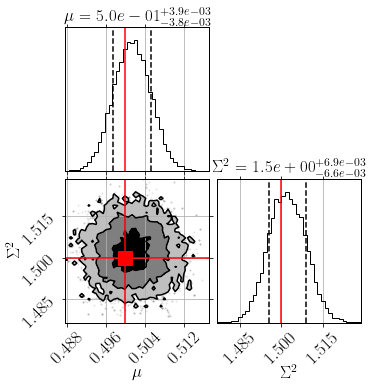

In [14]:
"""
Corner plot.
"""

labels = [r'$\mu$',r'$\Sigma^2 $']
truths=[true_mu, true_Sigma_sq]

fig = corner.corner(org_samp, bins=40,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

plt.show()

## Case II: MCMC including selection effects

In the second case we consider, we add selection effects in the analysis. This means we introduce a threshold in the data. Above this threshold, we "observe" a particular data draw. Below, we don't.

In [13]:
d_th = 0.5 #threshold for data.

data_sel_bias = data[data > d_th]
N_det = len(data_sel_bias)

print('Number detected events:', N_det)

Number detected events: 49932


The observed and underlying distributions ("populations") now differ quite considerably.

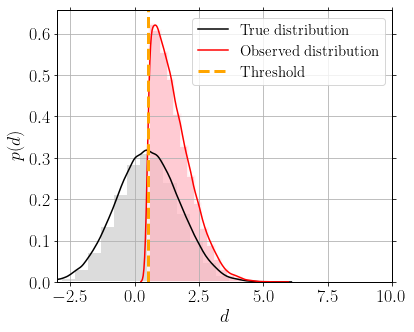

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(data,density=True,bins=20, histtype = 'stepfilled',
         color='gainsboro', edgecolor='white',lw=3)
plt.hist(data_sel_bias,density=True, bins=20,histtype = 'stepfilled',
         color='lightpink', edgecolor='white',lw=3,alpha=0.7)

sns.kdeplot(np.array(data), color='black',label='True distribution',)
sns.kdeplot(np.array(data_sel_bias), color='red',label='Observed distribution',)


plt.axvline(x=d_th, linestyle='-', c='orange', label='Threshold',ls='--', lw=3)
plt.xlabel('$d$')
plt.ylabel('$p(d)$')
plt.xlim(-3,10)
plt.legend(loc='best')

The likelihood in the case in which we have selection effects is

$$
p(d|\lambda) \equiv \Lambda = \prod_{i=1}^{N_\text{det}} \frac{p(d_i|\lambda)}{p_{\text{det}(\lambda)}}, \quad
\log \Lambda = \sum_{i}^{N_\text{det}} \log \left[\frac{p(d_i|\lambda)}{p_\text{det}(\lambda)}\right] 
= - N_\text{det}\log p_\text{det}(\lambda) + \sum_{i}^{N_\text{det}} \log p(d_i|\lambda).
$$

The selection function is defined and integrated as 

$$
p_\text{det}(\lambda) \equiv \int_{d_\text{th}}^\infty p(d|\lambda)dd =\int_{d_\text{th}}^\infty \frac{1}{\sqrt{2\pi (\sigma^2+\Sigma^2)}} \exp\left[-\frac{(d-\mu)^2}{2(\sigma^2+\Sigma^2)}\right]
dd = \frac{1}{2}\text{erfc}\left[\frac{d_\text{th}-\mu}{\sqrt{2(\sigma^2+\Sigma^2)}}\right].
$$

In [15]:
from scipy.special import erfc


def log_likelihood_selection_effect(params, data):
    
    # Specify a set of flat priors.
    support = (
                (params[0] >= mean_min_prior)&
                (params[0] <= mean_max_prior)&
                (params[1] >= Sigma_sq_min_prior)&
                (params[1] <= Sigma_sq_max_prior)
              )
    
    
    #Likelihood is a gaussian with mean given by params[0] and Sigma given by params[1].
    #In this case, we also include a selection function pdet_lambda.
    #Sum in the log-likelihood sums over individual observations.
    
    mod = model(data,params[0],params[1])
    pdet_lambda = 0.5 * erfc((d_th - params[0])/np.sqrt(2 * params[1]))
    log_likelihood = np.sum(np.log(mod/pdet_lambda))

    
    # Output is the likelihood where there is support.
    
    out = np.where(support,log_likelihood,-np.inf)
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf

In [16]:
"""
Run the MCMC.
"""

n_iter = 30000
ndim, nwalkers = 2, 16

pos_init0 = [true_mu, true_Sigma_sq + sigma**2 ]

p0 = pos_init0*(1+0.01* np.random.randn(8*len(pos_init0), len(pos_init0)))

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                log_likelihood_selection_effect, args=[data_sel_bias])
run_2 = sampler.run_mcmc(p0, n_iter, progress=True)

100%|█████████████████████████████████████| 30000/30000 [06:19<00:00, 79.00it/s]


In [17]:
"""
Collect the samples here.
"""
burnin = 1500

chains_selbias = sampler.get_chain(discard=burnin, thin=1, flat=False)
mu_samples_selbias = chains_selbias[:,:,0].flatten()
Sigma2_samples_selbias = chains_selbias[:,:,1].flatten() - sigma**2  # remove sigma component to show results for Sigma^2.

In [18]:
import pickle

with open('data_files/mu_samples_selbias.pickle', 'wb') as handle:
    pickle.dump(mu_samples_selbias, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('data_files/Sigma2_samples_selbias.pickle', 'wb') as handle:
    pickle.dump(Sigma2_samples_selbias, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
"""
Gather all the relevant samples here for the corner plots.
"""

org_samp_selbias = np.vstack( (mu_samples_selbias, Sigma2_samples_selbias) ).T
print("number of samples = ", np.shape(org_samp_selbias))
print("median = ", np.median(org_samp_selbias,axis=0))

number of samples =  (456000, 2)
median =  [0.55632548 1.45075263]


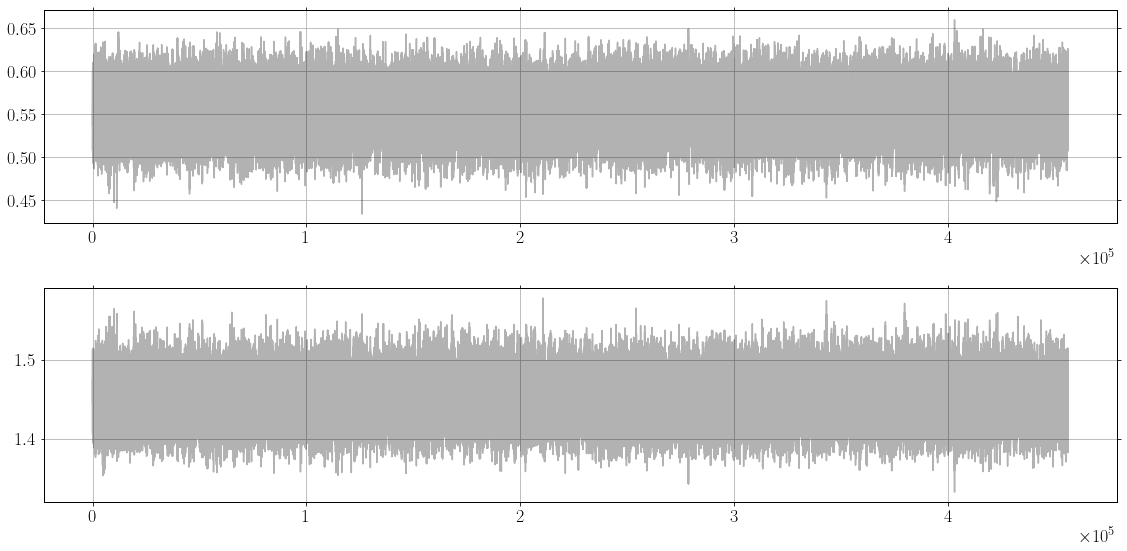

In [20]:
"""
Plot traces.
"""

fig,ax = plt.subplots(len(pos_init0),figsize = (16,8))

ax[0].plot(mu_samples_selbias, "k", alpha=0.3)
ax[1].plot(Sigma2_samples_selbias, "k", alpha=0.3)
plt.tight_layout()
plt.show()

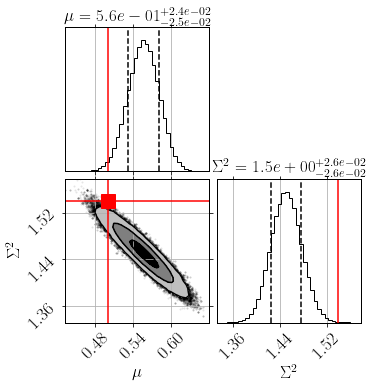

In [21]:
import matplotlib.patches as mpatches


"""
Corner plots.
"""
labels = [r'$\mu$',r'$\Sigma^2$']
truths=[true_mu, true_Sigma_sq + sigma**2]

corner.corner(org_samp_selbias, bins=40,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)
plt.show()